### **This notebook demonstrates the following:** 
1) Simulation of i.i.d. data with nonlinear, nonidentifiable causal transformations.<br><br>
2) Application of the 14 causal disocvery techniques included in our benchmark study on a demo version of the simulated datasets, i.e., <br>a small portion of them.<br><br>
3) Evaluation of inferred graphs using the six-dimensional performance indicator DOS. 

In [1]:
#Relevant imports
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("..")

#Data simulation imports:
import pickle
import pandas as pd
import numpy as np
from Data_Simulation_Framework.IID_Data_Generation_Process import lin_func,relu_func, Data_Generation_Process
from Results_Visualization.Visualization_Tools import plot_sf_er_graph_NodesEdgesMapping
from Causal_Discovery_Models.Causal_Discovery import Causal_Discovery
from Src.Utils import python_pickle_to_rds_r
from Performance_Evaluation_Framework.Explainable_Boosting_Machine import EBM
from Performance_Evaluation_Framework.Multidimensional_Performance_Indicator import DOS

2024-11-30 23:41:35,381 - C:\Users\Georg Velev\anaconda3\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-11-30 23:41:35,518 - C:\Users\Georg Velev\anaconda3\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


### **1. Simulation of i.i.d. Data with nonlinear, nonidentifiable causal Transformations**

In [2]:
#Initialize the data generator instance with the parameter values for each of the seven experimental factors 
#included in our benchmark study:
nonlinear_pattern='ReLU'
nonlinearities=[[(1.0,lin_func)],#linear patterns only
                [(0.5,lin_func),(0.5,relu_func)],#equal probability
               [(0.3,lin_func),(0.7,relu_func)],#70% probability relu
                [(0.1,lin_func),(0.9,relu_func)]]#90% probability relu

data_generator=Data_Generation_Process(beta_lower_limit=0.5,
                betta_upper_limit_values=[1.0,2.0,3.0,4.0],
                cont_noise=1.0,
                nr_nodes_values=[10,20,50,100],
                edge_desnity_values=[0.2,0.3,0.4],
                data_scale_values=['original','standardized'],
                num_samples=2500,
                nonlinearities=nonlinearities)

#First simulate the i.i.d. datasets based on the ER graph model:
er_simulation=data_generator.large_scale_simulation(graph_type='ER')

#Save large sample size ER-base data:
data_generator.save_data(frames_descriptions=er_simulation[0],
                         true_causal_matrices=er_simulation[1],true_weighted_causal_matrices=er_simulation[2],
                         frames=er_simulation[3],nonlinear_pattern=nonlinear_pattern,
                         graph_type='ER',sample_size='Large_Sample_Size',
                         save_path='../Data_Simulation_Framework/Simulated_Datasets/')

#Save small sample size ER-based data:
data_generator.save_data(frames_descriptions=er_simulation[0],
                         true_causal_matrices=er_simulation[1],true_weighted_causal_matrices=er_simulation[2],
                         frames=er_simulation[3],nonlinear_pattern=nonlinear_pattern,
                         graph_type='ER',sample_size='Small_Sample_Size',
                         save_path='../Data_Simulation_Framework/Simulated_Datasets/')

#Prepare avg number of edges per number of nodes for SF graph type based on already simulated ER connections:
avg_number_edges=data_generator.get_avg_number_edges_ER_graph(frames_descriptions=er_simulation[0],
                                                             save_path_edge_mapping='../Performance_Evaluation_Framework/Results/Avg_Number_Edges.pkl')

#Simulate SF-based data:
sf_simulation=data_generator.large_scale_simulation(graph_type='SF',avg_number_edges=avg_number_edges)

#Save large sample size SF-based data:
data_generator.save_data(frames_descriptions=sf_simulation[0],
                         true_causal_matrices=sf_simulation[1],true_weighted_causal_matrices=sf_simulation[2],
                         frames=sf_simulation[3],nonlinear_pattern=nonlinear_pattern,
                         graph_type='SF',sample_size='Large_Sample_Size',
                         save_path='../Data_Simulation_Framework/Simulated_Datasets/')

#Save small sample size SF-based data:
data_generator.save_data(frames_descriptions=sf_simulation[0],
                         true_causal_matrices=sf_simulation[1],true_weighted_causal_matrices=sf_simulation[2],
                         frames=sf_simulation[3],nonlinear_pattern=nonlinear_pattern,
                         graph_type='SF',sample_size='Small_Sample_Size',
                         save_path='../Data_Simulation_Framework/Simulated_Datasets/')

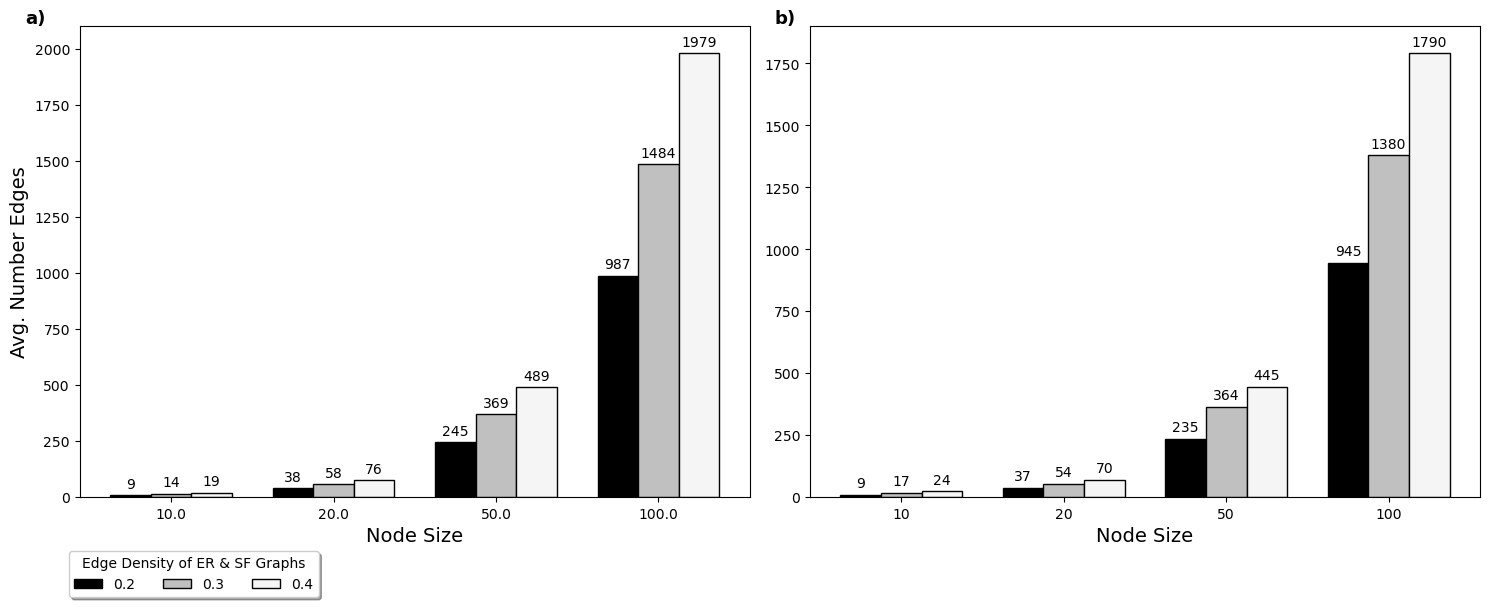

	Figure Caption: a) ER Graphs, b) SF Graphs


In [3]:
plot_sf_er_graph_NodesEdgesMapping(er_frames_descriptions=er_simulation[0],
                                      sf_frames_descriptions=sf_simulation[0])

In [ ]:
#Simulate 40 datasets with increased beta upper limit:
beta_upper_limit_generator=Data_Generation_Process(beta_lower_limit=0.5,
                betta_upper_limit_values=[1.0,4.0,6.0,8.0],
                cont_noise=1.0,nr_nodes_values=[20],
                edge_desnity_values=[0.3],data_scale_values=['original'],
                num_samples=2500,nonlinearities=[[(0.1,lin_func),(0.9,relu_func)]])

betas_simulaiton=beta_upper_limit_generator.large_scale_simulation(graph_type='SF',avg_number_edges={'Nodes_20':{0.3:avg_number_edges['Nodes_20'][0.3]}})

beta_upper_limit_generator.save_data(frames_descriptions=betas_simulaiton[0],
                         true_causal_matrices=betas_simulaiton[1],true_weighted_causal_matrices=betas_simulaiton[2],
                         frames=betas_simulaiton[3],nonlinear_pattern=nonlinear_pattern,
                         graph_type='SF',sample_size='Large_Sample_Size',
                         save_path='../Data_Simulation_Framework/Simulated_Datasets/Betas_')

### **2. Application of Causal Discovery Models on demo-version, i.e., smaller proportion of the simulated Data**

In [2]:
with open('../Data_Simulation_Framework/Simulated_Datasets/ER_Large_Sample_Size_Datasets_ReLU_10_nodes.pkl','rb') as f:
    frames_list=pickle.load(f)

In [4]:
causal_discovery=Causal_Discovery(frames_list=frames_list[:3],#taking only the first three simulated datasets
                                  #for demonstration purposes.
                                  index_frame_description=0,
                                  index_true_adjacency=1,
                                  index_true_weighted_adjacency=2,
                                  index_frame=3)
causal_discovery.extract_causal_graphs()
causal_discovery_demo=causal_discovery.causal_discovery_results
causal_discovery_demo_rds=[csl_itm.copy() for csl_itm in causal_discovery_demo]

DASK Client Dashboard Link:  http://127.0.0.1:8787/status
Using default cache_path: `C:\Users\Georg Velev\Desktop\Humboldt Uni\CSL_Benchmark_Study\Causal_Discovery_iid_Data\Src\cache`


2024-11-28 22:12:42,055 - C:\Users\Georg Velev\anaconda3\lib\site-packages\jax\_src\xla_bridge.py[line:622] - INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-11-28 22:12:42,057 - C:\Users\Georg Velev\anaconda3\lib\site-packages\jax\_src\xla_bridge.py[line:622] - INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-11-28 22:12:42,064 - C:\Users\Georg Velev\anaconda3\lib\site-packages\jax\_src\xla_bridge.py[line:622] - INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2024-11-28 22:12:42,065 - C:\Users\Georg Velev\anaconda3\lib\site-packages\jax\_src\xla_bridge.py[line:636] - WARNING: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
#Save the the results in RDS format:
save_file_path='../Performance_Evaluation_Framework/Results/Causal_Discovery_Results_Demo.rds'
python_pickle_to_rds_r(frames_list=causal_discovery_demo_rds,save_path=save_file_path)
#Run the script Hybrid_Bayesian_Networks.R in the folder Causal_Discovery_Models in order to
#collect the results for the same file from bayesian hybrid networks

In [8]:
#Append Results from hybrid bayesian networks computed in R to the python results list:
with open('../Performance_Evaluation_Framework/Results/Causal_Discovery_Results_Demo_Hybrid_Bayesian_Networks.pkl','rb') as f:
    causal_discovery_demo_hbn=pickle.load(f)

for csl_index in range(0,len(causal_discovery_demo)):
    #Convert the rds-to-pickle dataframe in python format and compare it to the frames in the python file,
    #to make sure that the results from hybrid bayesian networks are mapped to those from the other models:
    rds_frame=causal_discovery_demo_hbn[csl_index]['dataset']
    cols_array=[int(col) for col in rds_frame.columns]
    rds_frame.columns=cols_array
    indices=[int(index_value) for index_value in rds_frame.index]
    rds_frame.index=indices

    if causal_discovery_demo[csl_index][3].equals(rds_frame):
        causal_discovery_demo[csl_index][-1]['pctabu']=causal_discovery_demo_hbn[csl_index]['pctabu']
        causal_discovery_demo[csl_index][-1]['mmtabu']=causal_discovery_demo_hbn[csl_index]['mmtabu']
        causal_discovery_demo[csl_index][-1]['fedtabu']=causal_discovery_demo_hbn[csl_index]['fedtabu']
    else:
        print('Mismatch found at index: ',csl_index)

In [6]:
#Overwrite the frames list with all results in the instance of causal discovery & save it in the result folder:
causal_discovery.set_causal_discovery_results(current_csl_results=causal_discovery_demo)
causal_discovery.save_csl_results(save_path='../Performance_Evaluation_Framework/Results/Causal_Discovery_Results_Demo.pkl',
                                 save_for_evaluation=True)

In [11]:
len(list(causal_discovery_demo[0][-1].keys()))

14

### **3. Evaluation of inferred Graphs with the six-dimensional DOS:**

In [4]:
dataset_description_index=0
true_binary_adjacency_index=1
estimated_adjacencies_index=4
fpr_metric='NoTears'

sample_sizes=['Large_Sample_Size']#,'Small_Sample_Size']
number_nodes=['10_nodes']#,'20_nodes','50_nodes','100_nodes']
model_names=['NoTears', 'Gran-DAG', 'GOLEM',
             'NoCurl', 'AVICI','DIRECT-LINGAM',
             'DAGMA', 'NoTears_Nonlinear',
             'R2SortnRegress', 'DAS', 'PC_stable',
            'fedtabu','pctabu','mmtabu']

metrics=['tpr','fpr','normalized_shd',
         'f1_score','causal_order_divergence','normalized_sid']
best_scenario=np.array([1.0,0.0,0.0,
                        1.0,0.0,0.0])
worst_scenario=np.array([0.0,1.0,1.0,
                         0.0,1.0,1.0])
parallelization=True
file_path='../Performance_Evaluation_Framework/Results/'

DOS_evaluation=DOS(dataset_description_index=dataset_description_index,
                true_binary_adjacency_index=true_binary_adjacency_index,
                estimated_adjacencies_index=estimated_adjacencies_index,
                fpr_metric=fpr_metric,
                sample_sizes=sample_sizes,
                number_nodes=number_nodes,
                model_names=model_names,
                metrics=metrics,
                best_scenario=best_scenario,
                worst_scenario=worst_scenario,
                read_path=file_path,
                read_file_names=['Causal_Discovery_Results_Demo_Evaluation.pkl'],
                #for all results replace with ['ER_CSL_Results.pkl','SF_CSL_Results.pkl'] 
                save_path=file_path,
                save_file_names=['Causal_Discovery_Results_Demo_Evaluation.pkl'])
                #for all results evaluations replace with ['ER_CSL_Results_Evaluation.pkl','SF_CSL_Results_Evaluation.pkl']

DOS_evaluation.evaluate()
DOS_evaluation.create_results_dataframe(save_results_frame_name='Results_Demo_Frame.pkl')

Current Sample Size:  Large_Sample_Size 

Current Number Nodes:  10_nodes 

- Current CSL Result Index:  1 from a total of  3
- Current CSL Result Index:  2 from a total of  3
- Current CSL Result Index:  3 from a total of  3


In [7]:
results_df=DOS_evaluation.results_dataframe

In [8]:
results_df.head(10)

,Nr_Run,Nodes,Connectivity,Edges,Transformation_Function,Beta_Upper_Limit,Scale,Graph_Type,Sample_Size,CSL_Model,DOS,TPR,FPR,nSHD,FScore,DAG_Check,Eliminated_Edges,Causal_Order_Divergence,nSID
0,0,10,0.2,12,Linear_100%,1.0,original,ER,Large_Sample_Size,NoTears,1.000000,1.000000,0.000000,0.000000,1.000000,True,0,0.000000,0.000000
1,0,10,0.2,12,Linear_100%,1.0,original,ER,Large_Sample_Size,Gran-DAG,0.684478,0.416667,0.000000,0.411765,0.588235,True,0,0.000000,0.233333
2,0,10,0.2,12,Linear_100%,1.0,original,ER,Large_Sample_Size,GOLEM,1.000000,1.000000,0.000000,0.000000,1.000000,True,0,0.000000,0.000000
3,0,10,0.2,12,Linear_100%,1.0,original,ER,Large_Sample_Size,NoCurl,1.000000,1.000000,0.000000,0.000000,1.000000,True,0,0.000000,0.000000
4,0,10,0.2,12,Linear_100%,1.0,original,ER,Large_Sample_Size,AVICI,0.878164,0.833333,0.025641,0.125000,0.833333,True,0,0.083333,0.111111
5,0,10,0.2,12,Linear_100%,1.0,original,ER,Large_Sample_Size,DIRECT-LINGAM,0.733224,0.666667,0.064103,0.200000,0.640000,True,0,0.333333,0.233333
6,0,10,0.2,12,Linear_100%,1.0,original,ER,Large_Sample_Size,DAGMA,0.856450,0.833333,0.038462,0.120000,0.800000,True,0,0.166667,0.122222
7,0,10,0.2,12,Linear_100%,1.0,original,ER,Large_Sample_Size,NoTears_Nonlinear,0.904697,0.916667,0.038462,0.115385,0.846154,True,0,0.083333,0.055556
8,0,10,0.2,12,Linear_100%,1.0,original,ER,Large_Sample_Size,R2SortnRegress,0.933086,0.916667,0.012821,0.041667,0.916667,True,0,0.083333,0.066667
9,0,10,0.2,12,Linear_100%,1.0,original,ER,Large_Sample_Size,DAS,0.922215,0.916667,0.025641,0.120000,0.880000,True,0,0.000000,0.033333
